# EDA
Exploring the data. The general direction I would like to go is in plotting the trend of various produce overtime. In the meantime, I have to deduplicate and clean the data before I can adjust all prices for inflation. Since there are 22 different produce items, this will take some work.

In [604]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [605]:
# making a quick funciton to use for git
def git(message):
    '''Function adds, commits with message, and pushes to github'''
    !git add .
    !git commit -m f'{message}'
    !git push origin master

In [606]:
path_to_data = '../../data/00_raw/agriculture_prices.db'
conn = sqlite3.connect(path_to_data)
c = conn.cursor()

In [607]:
produce_df = pd.DataFrame(c.execute('''SELECT * FROM agriculture_prices''').fetchall())

In [608]:
produce_df.columns = ['Farm Price', 'Atlanta Retail', 'Chicago Retail', 'Los Angeles Retail', 'NYC Retail', 'Avg Spread', 'Commodity', 'Date']

In [609]:
produce_df.head()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,Date
0,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries,2019-05-19
1,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries,2019-05-12
2,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries,2019-05-05
3,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries,2019-04-28
4,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries,2019-04-21


In [610]:
produce_df.tail()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,Date
213791,0.28,1.69,0.0,1.24,1.19,267.86%,Nectarines,2000-07-23
213792,0.26,1.61,0.0,1.37,1.19,300.96%,Nectarines,2000-07-16
213793,0.30,1.71,0.0,1.42,1.19,260.00%,Nectarines,2000-07-09
213794,0.33,1.96,0.0,0.92,1.04,196.97%,Nectarines,2000-07-02
213795,0.39,1.22,0.0,0.92,1.19,113.46%,Nectarines,2000-06-25


In [611]:
produce_df.index = pd.to_datetime(produce_df['Date'])

In [612]:
produce_df.drop(columns=['Date'], inplace=True)

In [613]:
conn.close()

# Cleaning Data and Adding Features
Updating all prices to reflect 2019 dollars (adjust for inflation), and will be taking an average for all retail prices. 

Since this needs to be done by commodity, I am also going to make a dictionary that holds data frames by commodity, produce_dict. So for example, typing ``produce_dict['Strawberries']`` will return a dataframe concerning only strawberries.

In [614]:
produce_list = list(produce_df['Commodity'].unique())
produce_list

['Strawberries',
 'Romaine Lettuce',
 'Red Leaf Lettuce',
 'Potatoes',
 'Oranges',
 'Iceberg Lettuce',
 'Green Leaf Lettuce',
 'Celery',
 'Cauliflower',
 'Carrots',
 'Cantaloupe',
 'Broccoli Crowns',
 'Avocados',
 'Broccoli Bunches',
 'Asparagus',
 'Flame Grapes',
 'Thompson Grapes',
 'Honeydews',
 'Tomatoes',
 'Plums',
 'Peaches',
 'Nectarines']

In [615]:
produce_dict = dict()
for produce in produce_list:
    df_copy = produce_df[produce_df['Commodity'] == produce].copy() # Copying by slicing gives warning error
    produce_dict.setdefault(produce, df_copy)

# Looking at nan values

In [616]:
produce_dict['Strawberries'].isna().sum()

Farm Price            0
Atlanta Retail        0
Chicago Retail        0
Los Angeles Retail    0
NYC Retail            1
Avg Spread            0
Commodity             0
dtype: int64

In [617]:
produce_dict['Strawberries'].dropna(inplace=True)

In [618]:
produce_dict['Strawberries'].isna().sum()

Farm Price            0
Atlanta Retail        0
Chicago Retail        0
Los Angeles Retail    0
NYC Retail            0
Avg Spread            0
Commodity             0
dtype: int64

# Deduplicating Data

In [619]:
produce_dict['Strawberries'].duplicated().sum()

8

In [620]:
produce_dict['Strawberries'][produce_dict['Strawberries'].duplicated(keep=False)]

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2014-04-23,1.24,2.45,2.26,2.31,3.74,116.94%,Strawberries
2014-04-13,1.24,2.45,2.26,2.31,3.74,116.94%,Strawberries
2014-01-12,2.38,3.36,2.75,3.62,3.24,36.24%,Strawberries
2014-01-05,2.38,3.36,2.75,3.62,3.24,36.24%,Strawberries
2013-11-06,1.40,3.06,3.49,2.75,4.11,139.46%,Strawberries
2013-10-27,1.40,3.06,3.49,2.75,4.11,139.46%,Strawberries
2012-08-12,1.16,2.27,2.62,2.49,3.82,141.38%,Strawberries
2012-08-12,1.16,2.27,2.62,2.49,3.82,141.38%,Strawberries
2012-05-13,1.09,2.07,2.36,2.12,3.24,124.54%,Strawberries


# Want to drop repeated dates, but keep the rest. It is possible that no changes occurred between some of the data points

In [621]:
produce_dict['Strawberries'][produce_dict['Strawberries'].index.duplicated(keep=False)]

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2014-08-17,1.31,2.36,0.00,0.00,0.00,-54.96%,Strawberries
2014-08-17,1.31,2.36,2.57,3.12,2.49,101.15%,Strawberries
2012-08-12,1.16,2.27,2.62,2.49,3.82,141.38%,Strawberries
2012-08-12,1.16,2.27,2.62,2.49,3.82,141.38%,Strawberries
2012-05-13,1.09,2.07,2.36,2.12,3.24,124.54%,Strawberries
2012-05-13,1.09,2.07,2.36,2.12,3.24,124.54%,Strawberries
1999-11-07,1.22,3.09,0.00,3.66,3.16,103.07%,Strawberries
1999-11-07,1.22,3.09,0.00,3.66,3.16,103.07%,Strawberries


In [622]:
produce_dict['Strawberries'][produce_dict['Strawberries'].index.duplicated(keep=False)].index

DatetimeIndex(['2014-08-17', '2014-08-17', '2012-08-12', '2012-08-12',
               '2012-05-13', '2012-05-13', '1999-11-07', '1999-11-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [623]:
target_dates = produce_dict['Strawberries'][produce_dict['Strawberries'].index.duplicated(keep=False)].index

# Since I want to keep some of the data being claimed as duplicates, I can't just use drop_duplicates
Luckily there are only 4 rows to drop. I'll go in and drop them manually. 

In [624]:
count = 0
indices = []
for i in produce_dict['Strawberries'].index:
    if i in target_dates:
        indices.append(count)
        
    count += 1
        

In [625]:
indices

[242, 243, 345, 346, 359, 360, 967, 968]

In [626]:
produce_dict['Strawberries']['Date'] = produce_dict['Strawberries'].index
produce_dict['Strawberries'].index = np.arange(0, len(produce_dict['Strawberries'].index))

In [627]:
produce_dict['Strawberries'].drop([243, 346, 360, 968], inplace=True)

In [628]:
produce_dict['Strawberries'].index = produce_dict['Strawberries']['Date']
produce_dict['Strawberries'].drop(columns=['Date'], inplace=True)
produce_dict['Strawberries'].head()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries
2019-05-12,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries
2019-05-05,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries
2019-04-28,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries
2019-04-21,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries


In [629]:
produce_dict['Strawberries'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 980 entries, 2019-05-19 to 1999-07-26
Data columns (total 7 columns):
Farm Price            980 non-null float64
Atlanta Retail        980 non-null float64
Chicago Retail        980 non-null float64
Los Angeles Retail    980 non-null float64
NYC Retail            980 non-null float64
Avg Spread            980 non-null object
Commodity             980 non-null object
dtypes: float64(5), object(2)
memory usage: 61.2+ KB


In [630]:
produce_dict['Strawberries'].describe()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail
count,980.000000,980.000000,980.000000,980.0000,980.000000
mean,1.437898,2.843816,2.722704,3.0605,3.311265
std,0.645346,0.649029,1.015866,0.8561,0.853921
min,0.180000,1.120000,0.000000,0.0000,0.000000
25%,1.000000,2.370000,2.290000,2.4900,2.740000
50%,1.210000,2.735000,2.750000,2.8700,3.120000
75%,1.750000,3.162500,3.320000,3.6200,3.740000
max,3.750000,5.490000,5.740000,5.7400,6.490000


# Distribution of each column
Each column is slightly skewed in distribution, but not so bad (comparing mean and median). Will expand on normality later. The zeroed entries are a problem (Don't think free strawberries were given out for months). Likely what was written in lieu of NaN. How many zero's are there?

In [631]:
sum(produce_dict['Strawberries']['Farm Price'] == 0)

0

In [632]:
sum(produce_dict['Strawberries']['Atlanta Retail'] == 0)

0

In [633]:
sum(produce_dict['Strawberries']['Chicago Retail'] == 0)

67

In [634]:
sum(produce_dict['Strawberries']['Los Angeles Retail'] == 0)

3

In [635]:
sum(produce_dict['Strawberries']['NYC Retail'] == 0)

2

In [636]:
def count_zeros(data_frame):
    columns = list(data_frame.columns)
    '''Prints the counts of all the zeros in each column of the given produce dataframe'''
    
    print('Farm Price: ',sum(data_frame[columns[0]] == 0))
    print('Atlanta Retail: ',sum(data_frame[columns[1]]==0))
    print('Chicago Retail: ',sum(data_frame[columns[2]] == 0))
    print('Los Angeles Retail: ',sum(data_frame[columns[3]]==0))
    print('NYC Retail: ',sum(data_frame[columns[4]] == 0))
   

In [637]:
count_zeros(produce_dict['Strawberries'])

Farm Price:  0
Atlanta Retail:  0
Chicago Retail:  67
Los Angeles Retail:  3
NYC Retail:  2


# Chicago has a lot of zeros
I can drop them... but I think it might be better to replace them with the annual median value. 

May want to revisit this decision and see how different my results are if I drop them.

In [638]:
produce_dict['Strawberries'].resample('Y').median()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail
Date,,,,,
1999-12-31,0.710,2.740,0.000,2.940,2.960
2000-12-31,0.910,2.370,0.000,2.620,2.495
2001-12-31,1.210,2.990,2.850,2.890,2.750
2002-12-31,1.030,2.760,3.215,2.795,2.870
2003-12-31,1.200,2.930,2.870,2.870,3.120
2004-12-31,1.245,2.865,3.025,3.105,3.265
2005-12-31,1.140,2.740,2.740,2.870,3.120
2006-12-31,1.270,2.810,3.120,2.870,3.120
2007-12-31,1.500,2.870,3.180,2.990,3.370


# Median values are missing for 1999 and 2000
Going to try to estimate these data points. Plotting them for now to judge how to estimate

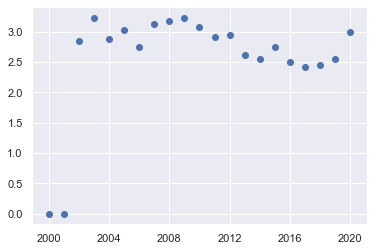

In [639]:
chicago_median = produce_dict['Strawberries'].resample('Y').median()['Chicago Retail']
plt.scatter(produce_dict['Strawberries'].resample('Y').median().index, chicago_median)

#  Polynomial Regression
Going to estimate the 1999 and 2000 median prices for Chicago Retail with a polynomial regression. This is looks trivial, but I welcome the practice. Could use scikitlearn, but that seems a bit overkill. I am going to use numpy for it.

In [640]:
chicago_x = np.arange(2001, 2020)
chicago_y = chicago_median[2:]
full_x = np.arange(1999, 2020)

In [641]:
poly1_coeff = np.polyfit(chicago_x, chicago_y, deg=1)
poly2_coeff = np.polyfit(chicago_x, chicago_y, deg=2)
poly3_coeff = np.polyfit(chicago_x, chicago_y, deg=3)

In [642]:
y_fit1 = np.poly1d(poly1_coeff)
y_fit2 = np.poly1d(poly2_coeff)
y_fit3 = np.poly1d(poly3_coeff)

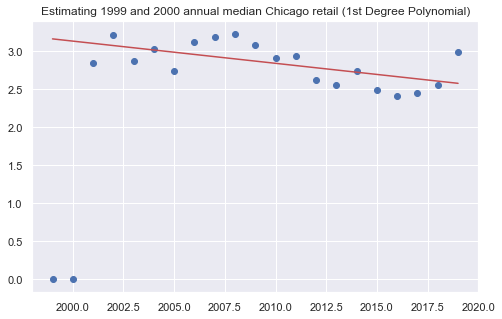

In [643]:
plt.figure(figsize=(8,5))
plt.title('Estimating 1999 and 2000 annual median Chicago retail (1st Degree Polynomial)')
plt.scatter(full_x, chicago_median)
plt.plot(full_x, y_fit1(full_x), c='r')

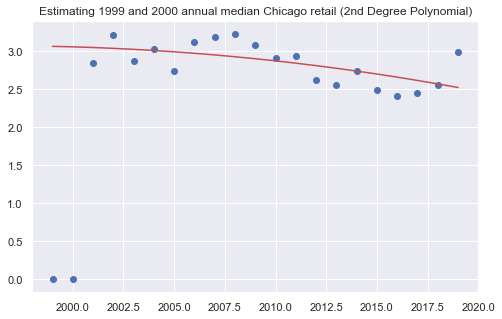

In [644]:
plt.figure(figsize=(8,5))
plt.title('Estimating 1999 and 2000 annual median Chicago retail (2nd Degree Polynomial)')
plt.scatter(full_x, chicago_median)
plt.plot(full_x, y_fit2(full_x), c='r')

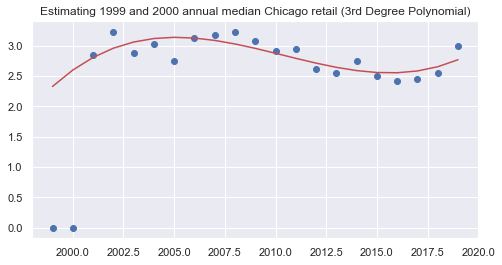

In [645]:
plt.figure(figsize=(8,4))
plt.title('Estimating 1999 and 2000 annual median Chicago retail (3rd Degree Polynomial)')
plt.scatter(full_x, chicago_median)
plt.plot(full_x, y_fit3(full_x), c='r')

# Judging the fits
The 1st degree polynomial appears to underfit the data, while the 3rd degree polynomial overfits. Using the second degree polynomial to estimate the medians.

In [646]:
chicago_median['1999-12-31'] = y_fit2(1999)
chicago_median['2000-12-31'] = y_fit2(2000)
chicago_median.index = chicago_median.index.year
chicago_median

Date
1999    3.063497
2000    3.056914
2001    2.850000
2002    3.215000
2003    2.870000
2004    3.025000
2005    2.740000
2006    3.120000
2007    3.180000
2008    3.230000
2009    3.080000
2010    2.905000
2011    2.940000
2012    2.620000
2013    2.550000
2014    2.740000
2015    2.490000
2016    2.410000
2017    2.450000
2018    2.555000
2019    2.990000
Name: Chicago Retail, dtype: float64

# Replacing zeros in Chicago Retail

In [647]:
for index in produce_dict['Strawberries']['Chicago Retail'].index:
        value = produce_dict['Strawberries'].loc[index, 'Chicago Retail']
        
        if ~value.any():
            print(index)
            year = index.year
            produce_dict['Strawberries'].loc[index, 'Chicago Retail'] = chicago_median.loc[year] 
            

2014-08-17 00:00:00
2001-01-28 00:00:00
2001-01-21 00:00:00
2001-01-07 00:00:00
2000-12-31 00:00:00
2000-10-22 00:00:00
2000-10-15 00:00:00
2000-10-08 00:00:00
2000-10-01 00:00:00
2000-09-24 00:00:00
2000-09-17 00:00:00
2000-09-10 00:00:00
2000-09-03 00:00:00
2000-08-27 00:00:00
2000-08-20 00:00:00
2000-08-13 00:00:00
2000-08-06 00:00:00
2000-07-30 00:00:00
2000-07-23 00:00:00
2000-07-16 00:00:00
2000-07-09 00:00:00
2000-07-02 00:00:00
2000-06-25 00:00:00
2000-06-18 00:00:00
2000-06-11 00:00:00
2000-06-04 00:00:00
2000-05-28 00:00:00
2000-05-21 00:00:00
2000-05-14 00:00:00
2000-05-07 00:00:00
2000-04-30 00:00:00
2000-04-23 00:00:00
2000-04-16 00:00:00
2000-04-09 00:00:00
2000-04-02 00:00:00
2000-03-26 00:00:00
2000-03-19 00:00:00
2000-03-12 00:00:00
2000-03-05 00:00:00
2000-02-27 00:00:00
2000-02-20 00:00:00
2000-02-13 00:00:00
2000-02-06 00:00:00
2000-01-30 00:00:00
2000-01-23 00:00:00
2000-01-16 00:00:00
2000-01-09 00:00:00
2000-01-02 00:00:00
1999-12-26 00:00:00
1999-11-21 00:00:00


In [648]:
value = produce_dict['Strawberries'].loc['2014-08-17', 'Chicago Retail']
value

Date
2014-08-17    2.74
Name: Chicago Retail, dtype: float64

In [649]:
count_zeros(produce_dict['Strawberries'])

Farm Price:  0
Atlanta Retail:  0
Chicago Retail:  0
Los Angeles Retail:  3
NYC Retail:  2


# Chicago is good. Handling the rest of these manually.

In [650]:
produce_dict['Strawberries']

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2019-05-19,1.16,2.23,1.700000,1.99,2.54,82.33%,Strawberries
2019-05-12,0.91,2.67,1.890000,2.47,2.66,166.21%,Strawberries
2019-05-05,0.58,2.42,1.890000,2.12,2.91,302.59%,Strawberries
2019-04-28,0.58,2.79,1.950000,2.38,2.96,334.48%,Strawberries
2019-04-21,0.69,2.92,2.040000,2.38,3.16,280.43%,Strawberries
...,...,...,...,...,...,...,...
1999-08-23,0.72,2.62,3.063497,3.12,2.59,189.24%,Strawberries
1999-08-16,0.58,2.44,3.063497,3.22,2.77,263.36%,Strawberries
1999-08-09,0.65,2.49,3.063497,2.99,2.87,221.15%,Strawberries


In [651]:
produce_dict['Strawberries'][produce_dict['Strawberries']['Los Angeles Retail'] == 0]

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2014-08-17,1.31,2.36,2.74,0.0,0.00,-54.96%,Strawberries
2004-02-08,2.11,2.87,2.83,0.0,3.12,4.50%,Strawberries
2003-01-05,2.06,4.68,3.99,0.0,4.32,57.65%,Strawberries


In [652]:
produce_dict['Strawberries'].loc['2014-08-17', 'Los Angeles Retail'] = 2.870
produce_dict['Strawberries'].loc['2004-02-08', 'Los Angeles Retail'] = 3.105
produce_dict['Strawberries'].loc['2003-01-05', 'Los Angeles Retail'] = 2.870

In [653]:
count_zeros(produce_dict['Strawberries'])

Farm Price:  0
Atlanta Retail:  0
Chicago Retail:  0
Los Angeles Retail:  0
NYC Retail:  2


In [654]:
produce_dict['Strawberries'][produce_dict['Strawberries']['NYC Retail'] == 0]

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2014-08-17,1.31,2.36,2.74,2.87,0.0,-54.96%,Strawberries
2005-12-18,3.46,4.32,4.82,4.74,0.0,0.29%,Strawberries


In [655]:
produce_dict['Strawberries'].loc['2014-08-17', 'NYC Retail'] = 3.360
produce_dict['Strawberries'].loc['2005-12-18', 'NYC Retail'] = 3.120

In [656]:
count_zeros(produce_dict['Strawberries'])

Farm Price:  0
Atlanta Retail:  0
Chicago Retail:  0
Los Angeles Retail:  0
NYC Retail:  0


# Strawberries Data Frame is clean.

After converting prices to 2019 dollars, store in database

Adjusting prices for inflation based on month using the consumer price index data found here [https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/](https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/)

Everything will be changed to correspond to USD in November of 2019

In [657]:
cpi_df = pd.read_csv('../../data/00_raw/cpi.csv', index_col=0, header=1)

In [658]:
cpi_df

,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec,Avg,Dec-Dec,Avg-Avg
Year,,,,,,,,,,,,,,,
1913,9.800,9.800,9.800,9.800,9.700,9.800,9.900,9.900,10.000,10.000,10.100,10.000,9.900,–,–
1914,10.000,9.900,9.900,9.800,9.900,9.900,10.000,10.200,10.200,10.100,10.200,10.100,10.000,1,1
1915,10.100,10.000,9.900,10.000,10.100,10.100,10.100,10.100,10.100,10.200,10.300,10.300,10.100,2,1
1916,10.400,10.400,10.500,10.600,10.700,10.800,10.800,10.900,11.100,11.300,11.500,11.600,10.900,12.6,7.9
1917,11.700,12.000,12.000,12.600,12.800,13.000,12.800,13.000,13.300,13.500,13.500,13.700,12.800,18.1,17.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,237.017,0.7,0.1
2016,236.916,237.111,238.132,239.261,240.236,241.038,240.647,240.853,241.428,241.729,241.353,241.432,240.007,2.1,1.3
2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,245.120,2.1,2.1


# Conversion to 2019 dollars
This is going to be a little bit tricky. The objective is to translate all prices in the dataframes to 2019 dollars of the most recent cpi. I have to match the month and year from the index of the produce data frames to the month and year from the cpi data frame and multiply by todays cpi divided by the cpi during that month and year.

First method I can immediately think of is to loop through each dataframe and apply the conversion where the months and year match. This isn't so bad on this dataframe but for large data it would be inefficient. In that case I would start thinking about how you could use arrays to process the data.

In [659]:
cpi_cols = ['1', '2', '3' , '4', '5', '6', '7', '8', '9', '10', '11', '12', 'Avg', 'Dec-Dec', 'Avg-Avg']

In [660]:
cpi_df.columns = cpi_cols

In [661]:
produce_dict['Strawberries'].index[0].month

5

In [662]:
cpi_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,Avg,Dec-Dec,Avg-Avg
Year,,,,,,,,,,,,,,,
1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,9.9,–,–
1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,10.0,1,1
1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,10.1,2,1
1916,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,10.9,12.6,7.9
1917,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,12.8,18.1,17.4


In [663]:
CPI_2019 = cpi_df.loc[2019][10] # Data frame is zero indexed... 0 is Jan and 1 is Feb etc for second argument.

In [664]:
CPI_2019

257.20799999999997

In [665]:
produce_dict['Strawberries'].head()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries
2019-05-12,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries
2019-05-05,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries
2019-04-28,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries
2019-04-21,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries


In [666]:
type(produce_dict['Strawberries'].loc['2019-04-21']['Los Angeles Retail'].values[0])

numpy.float64

In [674]:
farm = []
atl = []
chi=[]
la=[]
nyc =[]

for index_row in produce_dict['Strawberries'].index:
    count = 0
    for column in produce_dict['Strawberries'].columns:
        conversion = (CPI_2019/cpi_df.loc[index_row.year][index_row.month - 1])
        value = produce_dict['Strawberries'][str(index_row)][str(column)].values[0]*conversion
        if column == 'Farm Price':
            farm.append(value)
        elif column == 'Atlanta Retail':
            atl.append(value)
            
        elif column == 'Chicago Retail':
            chi.append(value)
            
        elif column == 'Los Angeles Retail':
            la.append(value)
            
        elif column == 'NYC Retail':
            nyc.append(value)
            
        count+=1
        if count == 5:
            break
        


In [678]:
adj_2019_dict = {}

adj_2019_dict.setdefault('2019 Farm Price', farm)
adj_2019_dict.setdefault('2019 Atlanta retail', atl)
adj_2019_dict.setdefault('2019 Chicago Retail', chi)
adj_2019_dict.setdefault('2019 Los Angeles Retail',la)
adj_2019_dict.setdefault('2019 NYC Retail', nyc)

strawberry_df_2019_adj = pd.DataFrame(adj_2019_dict)
strawberry_df_2019_adj.index = produce_dict['Strawberries'].index

In [679]:
strawberry_df_2019_adj

,2019 Farm Price,2019 Atlanta retail,2019 Chicago Retail,2019 Los Angeles Retail,2019 NYC Retail
Date,,,,,
2019-05-19,1.165055,2.239718,1.707408,1.998672,2.551069
2019-05-12,0.913966,2.681635,1.898236,2.480764,2.671592
2019-05-05,0.582528,2.430546,1.898236,2.129239,2.922681
2019-04-28,0.583768,2.808123,1.962667,2.395460,2.979228
2019-04-21,0.694482,2.938968,2.053252,2.395460,3.180527
...,...,...,...,...,...
1999-08-23,1.108257,4.032824,4.715476,4.802447,3.986647
1999-08-16,0.892763,3.755760,4.715476,4.956372,4.263711
1999-08-09,1.000510,3.832722,4.715476,4.602345,4.417636


In [670]:
produce_dict['Strawberries']

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2019-05-19,1.16,2.23,1.700000,1.99,2.54,82.33%,Strawberries
2019-05-12,0.91,2.67,1.890000,2.47,2.66,166.21%,Strawberries
2019-05-05,0.58,2.42,1.890000,2.12,2.91,302.59%,Strawberries
2019-04-28,0.58,2.79,1.950000,2.38,2.96,334.48%,Strawberries
2019-04-21,0.69,2.92,2.040000,2.38,3.16,280.43%,Strawberries
...,...,...,...,...,...,...,...
1999-08-23,0.72,2.62,3.063497,3.12,2.59,189.24%,Strawberries
1999-08-16,0.58,2.44,3.063497,3.22,2.77,263.36%,Strawberries
1999-08-09,0.65,2.49,3.063497,2.99,2.87,221.15%,Strawberries


# Strawberry Dataframe converted to 2019 USD 
(verified a few spots with a calculator as well). I would prefer to keep all updated dataframes in the dictionary and will reassign it back in

In [687]:
produce_dict['Strawberries'] = strawberry_df_2019_adj

# Creating an Average Retail out of the 4 available cities by averaging their columns. 

In [688]:
produce_dict['Strawberries']

,2019 Farm Price,2019 Atlanta retail,2019 Chicago Retail,2019 Los Angeles Retail,2019 NYC Retail
Date,,,,,
2019-05-19,1.165055,2.239718,1.707408,1.998672,2.551069
2019-05-12,0.913966,2.681635,1.898236,2.480764,2.671592
2019-05-05,0.582528,2.430546,1.898236,2.129239,2.922681
2019-04-28,0.583768,2.808123,1.962667,2.395460,2.979228
2019-04-21,0.694482,2.938968,2.053252,2.395460,3.180527
...,...,...,...,...,...
1999-08-23,1.108257,4.032824,4.715476,4.802447,3.986647
1999-08-16,0.892763,3.755760,4.715476,4.956372,4.263711
1999-08-09,1.000510,3.832722,4.715476,4.602345,4.417636


In [697]:
avg_retail = [np.mean(x[1:5]) for x in produce_dict['Strawberries'].values]
avg_retail_std = [np.var(x[1:5],ddof=1) for x in produce_dict['Strawberries'].values] #sample standard deviation
produce_dict['Strawberries']['Avg_Retail'] = avg_retail
produce_dict['Strawberries']['Avg_Retail_Var'] = avg_retail_std

In [698]:
produce_dict['Strawberries']

,2019 Farm Price,2019 Atlanta retail,2019 Chicago Retail,2019 Los Angeles Retail,2019 NYC Retail,Avg_Retail,Avg_Retail_Var
Date,,,,,,,
2019-05-19,1.165055,2.239718,1.707408,1.998672,2.551069,2.124217,0.128345
2019-05-12,0.913966,2.681635,1.898236,2.480764,2.671592,2.433057,0.135666
2019-05-05,0.582528,2.430546,1.898236,2.129239,2.922681,2.345175,0.195728
2019-04-28,0.583768,2.808123,1.962667,2.395460,2.979228,2.536370,0.206321
2019-04-21,0.694482,2.938968,2.053252,2.395460,3.180527,2.642052,0.261869
...,...,...,...,...,...,...,...
1999-08-23,1.108257,4.032824,4.715476,4.802447,3.986647,4.384349,0.188729
1999-08-16,0.892763,3.755760,4.715476,4.956372,4.263711,4.422830,0.280203
1999-08-09,1.000510,3.832722,4.715476,4.602345,4.417636,4.392045,0.154110


# Alright. Finally is ready for exploration. Observing data as it is now

<Figure size 1440x1440 with 0 Axes>

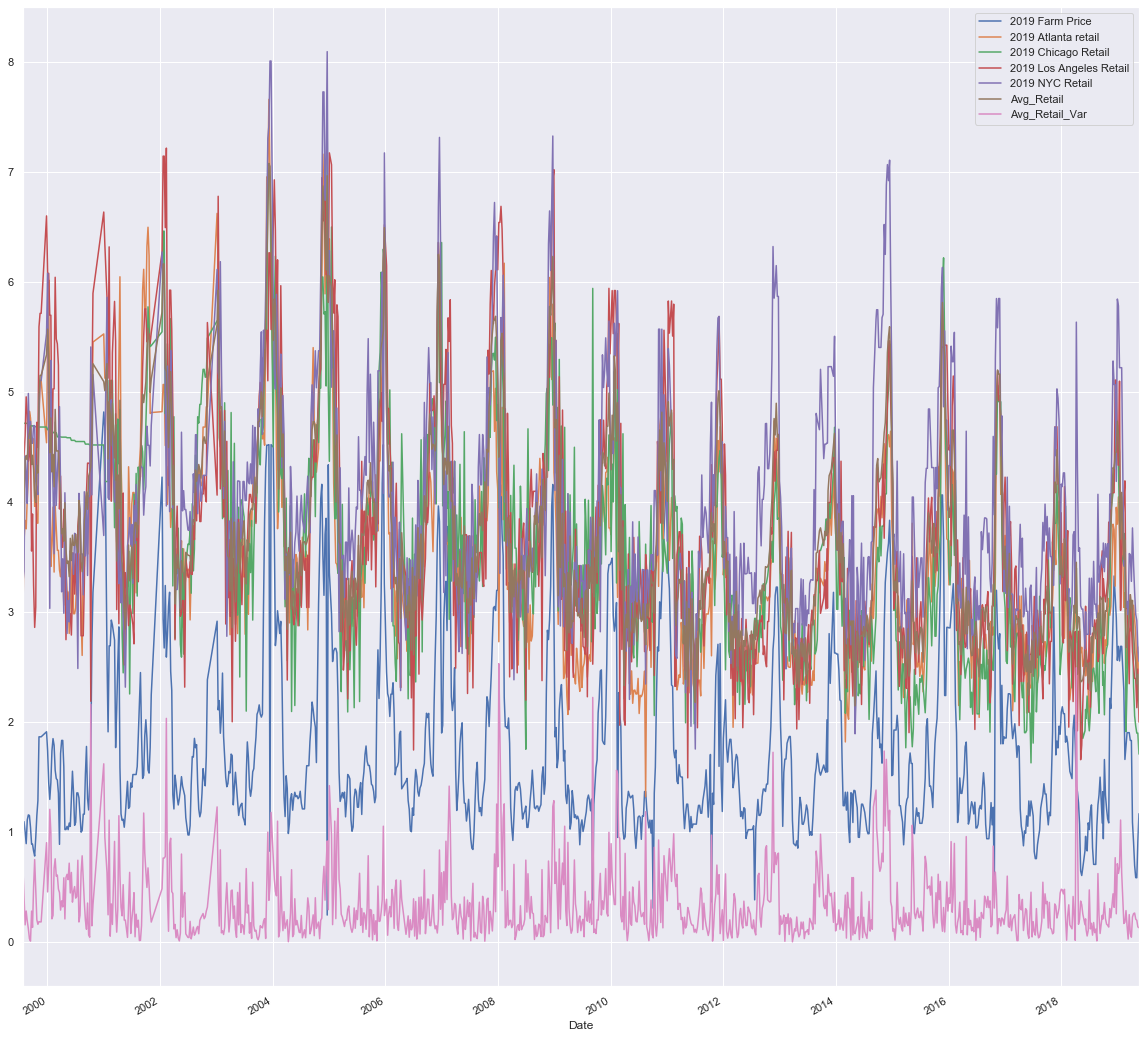

In [701]:
produce_dict['Strawberries'].plot(figsize=(20,20))

# There does seem to be a cycle happening on an approximately annual basis
Observing just farm price and avg retail next

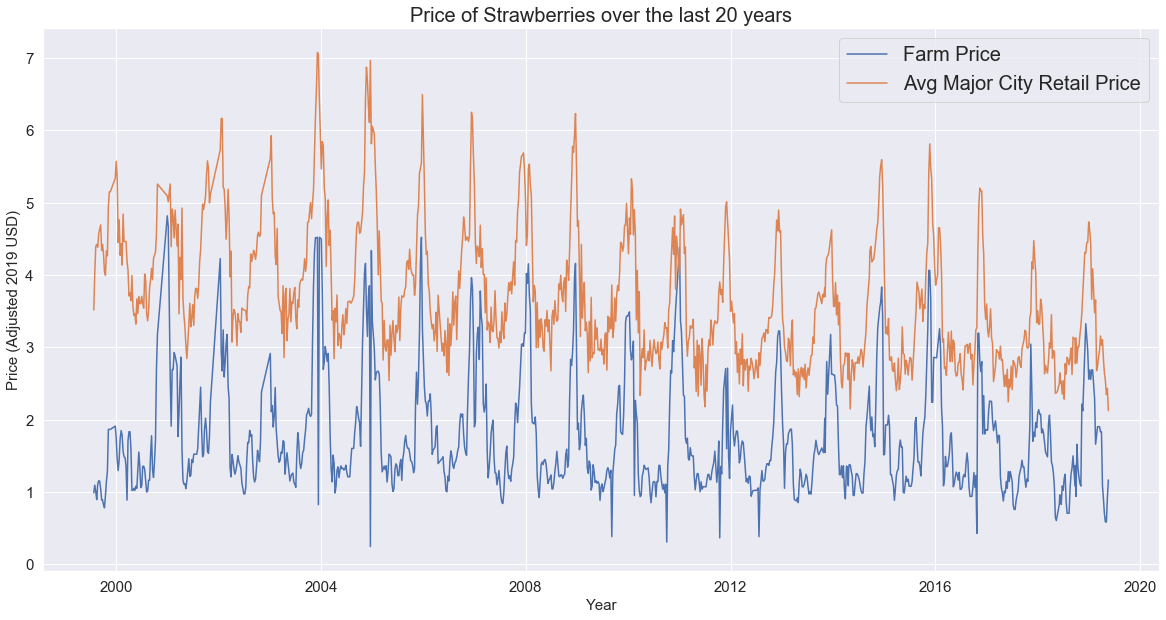

In [708]:
plt.figure(figsize=(20,10))
plt.plot(produce_dict['Strawberries'].index, produce_dict['Strawberries']['2019 Farm Price'], label='Farm Price')
plt.plot(produce_dict['Strawberries'].index, produce_dict['Strawberries']['Avg_Retail'], label='Avg Major City Retail Price')
plt.title('Price of Strawberries over the last 20 years',fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price (Adjusted 2019 USD)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.minorticks_on()

As expected, the price at the farm and the average retail price move together with the farm price being cheaper than the average retail. After adjusting for inflation, the farm price does appear to be relatively constant in its offset. The average retail price however looks like it may be sloping downward slightly. The graph shows the highest average retail price occuring just before 2004 and is then followed by it's second highest price in 2005. It is interesting that the price peak declined from 2004 to around 2014. Perhaps the recession affected sales in that people bought less strawberries. A surplus of produce would help explain the price drop. 

# How well do the prices correlate?

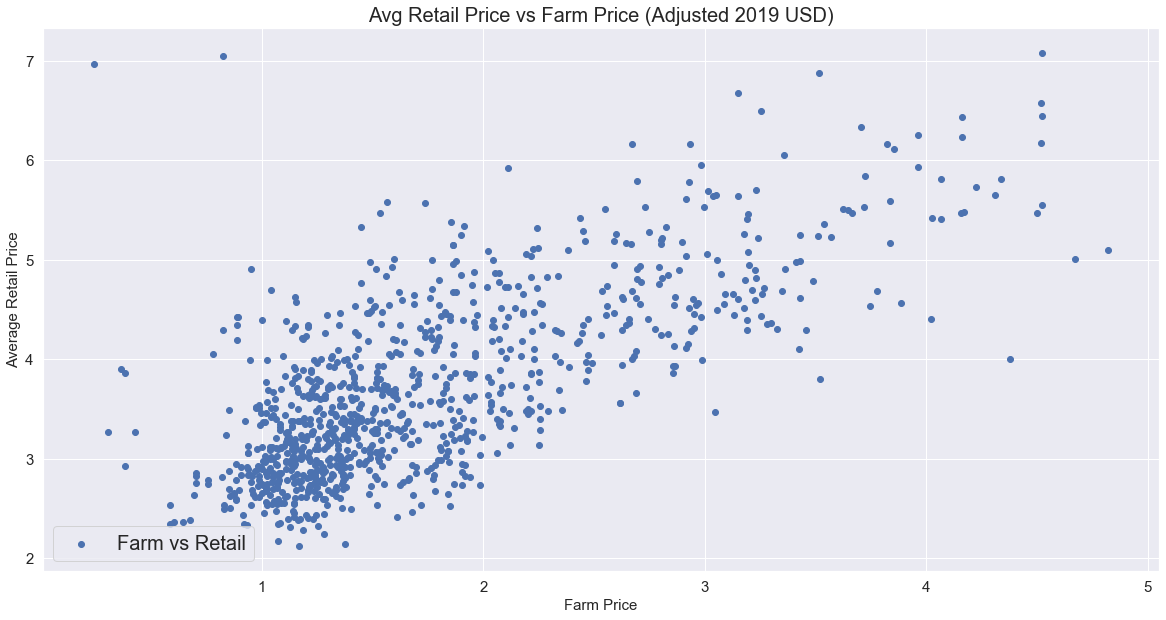

In [710]:
plt.figure(figsize=(20,10))
plt.scatter(produce_dict['Strawberries']['2019 Farm Price'], produce_dict['Strawberries']['Avg_Retail'], label='Farm vs Retail')
plt.title('Avg Retail Price vs Farm Price (Adjusted 2019 USD)',fontsize=20)
plt.xlabel('Farm Price', fontsize=15)
plt.ylabel('Average Retail Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.minorticks_on()